In [1]:
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

## Load in Data and Set Index

In [2]:
min_temp_data = pd.read_csv('/Users/ryangeygan/hacking/Datasets/daily-min-temperatures.csv')

In [3]:
min_temp_data.set_index('Date', inplace=True)
min_temp_data.index = pd.date_range(start=min_temp_data.index[0], periods=len(min_temp_data), freq='D')
min_temp_data = min_temp_data.rename(columns={'Temp':'min_temp'})

## Brief EDA

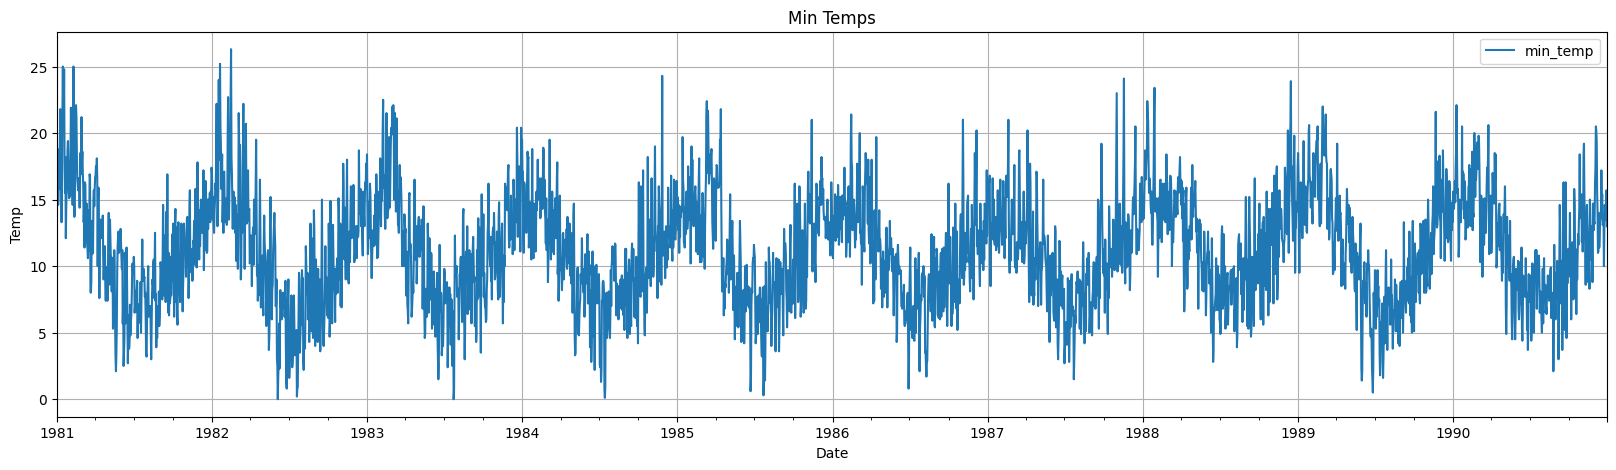

In [4]:
plt.rcParams['figure.figsize'] = [20, 5]

# Plotting
min_temp_data.plot()
plt.title('Min Temps')
plt.xlabel('Date')
plt.ylabel('Temp')
plt.grid(True)
plt.show()

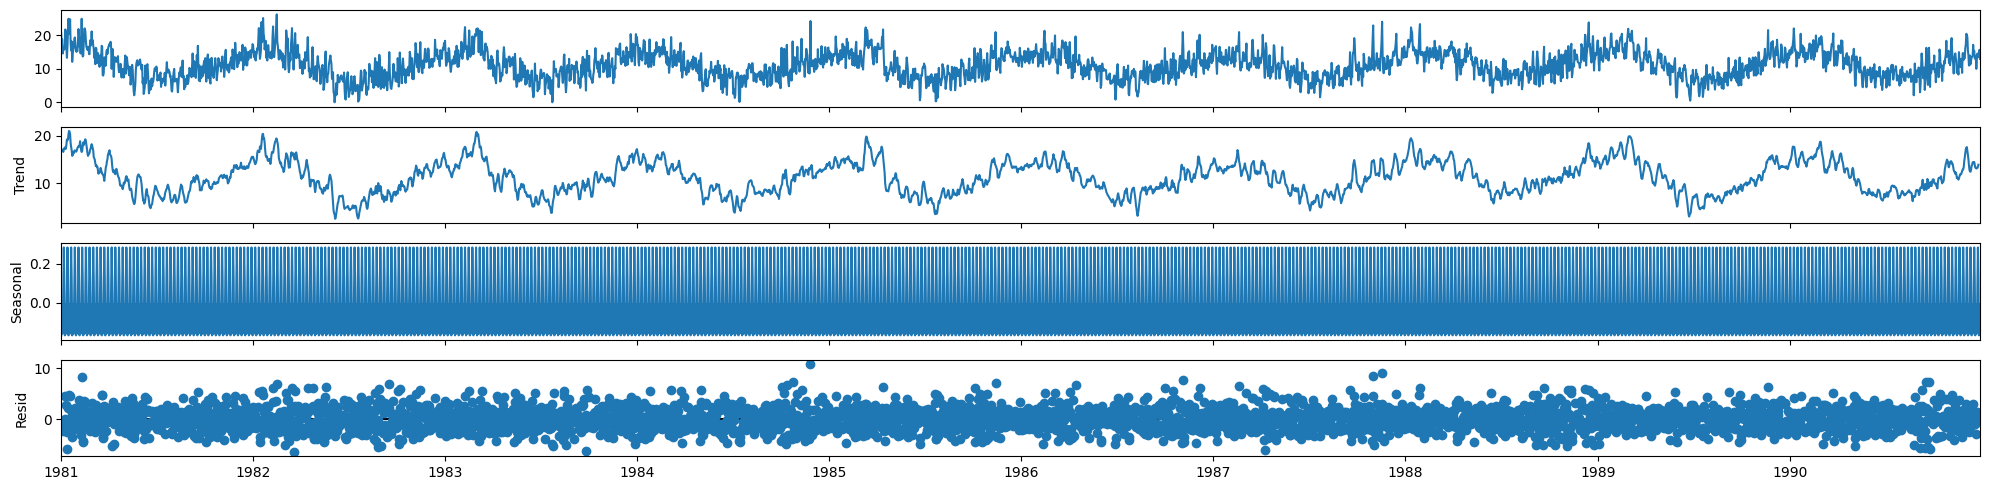

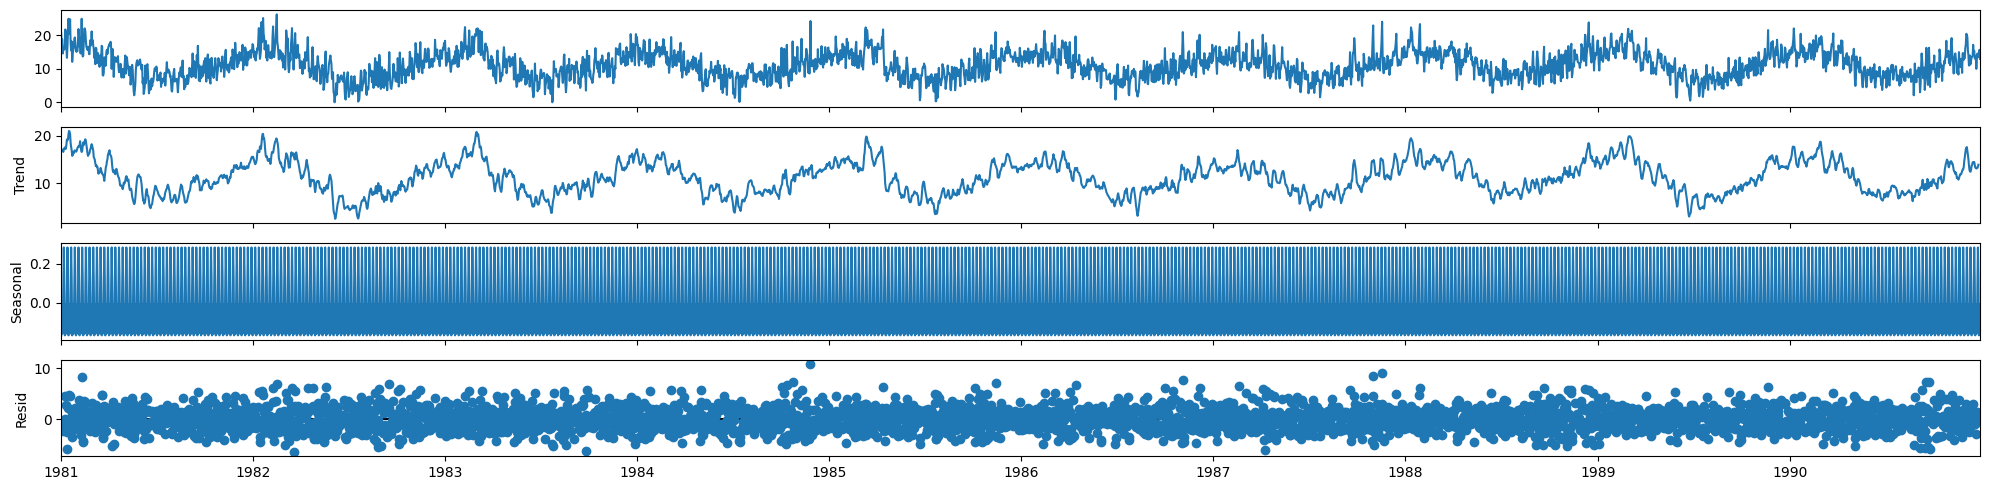

In [5]:
results = seasonal_decompose(min_temp_data)

results.plot()

## Resample the Data to Monthly and Repeat

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_34990/523218344.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = min_temp_data.resample('M').mean()


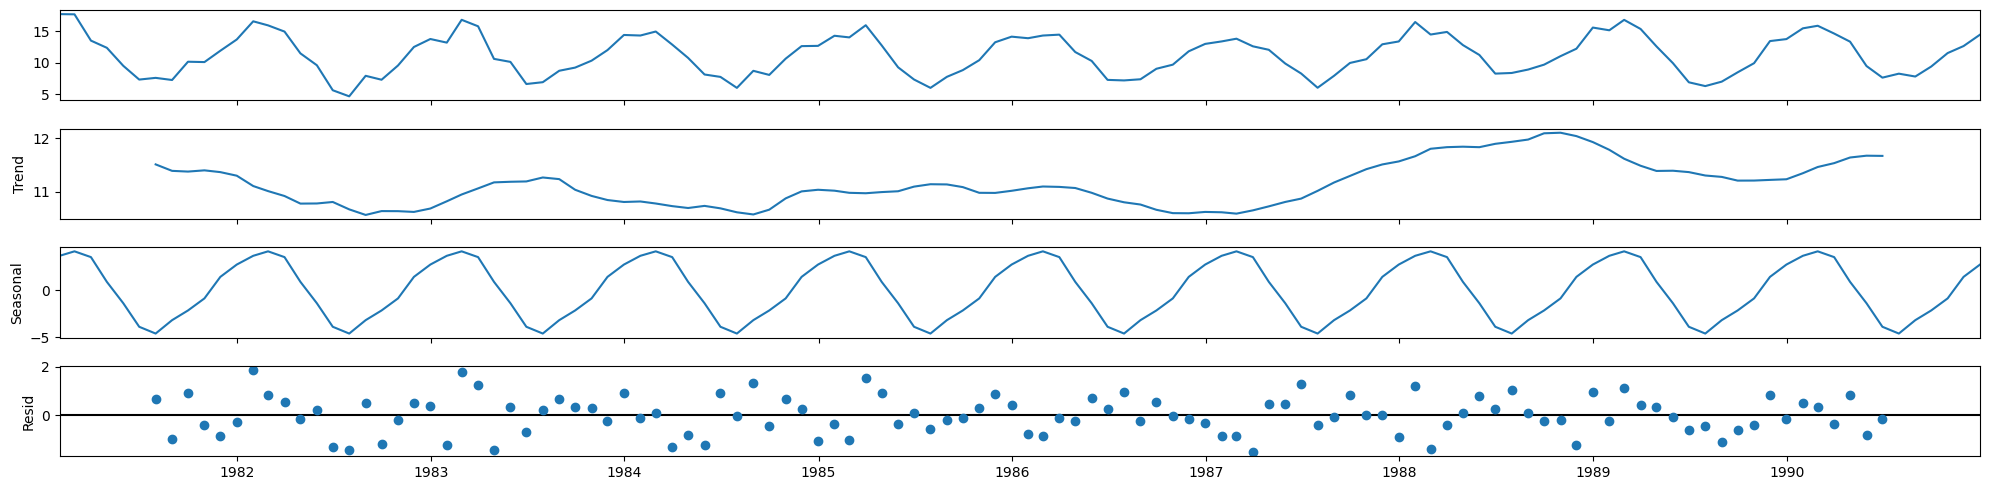

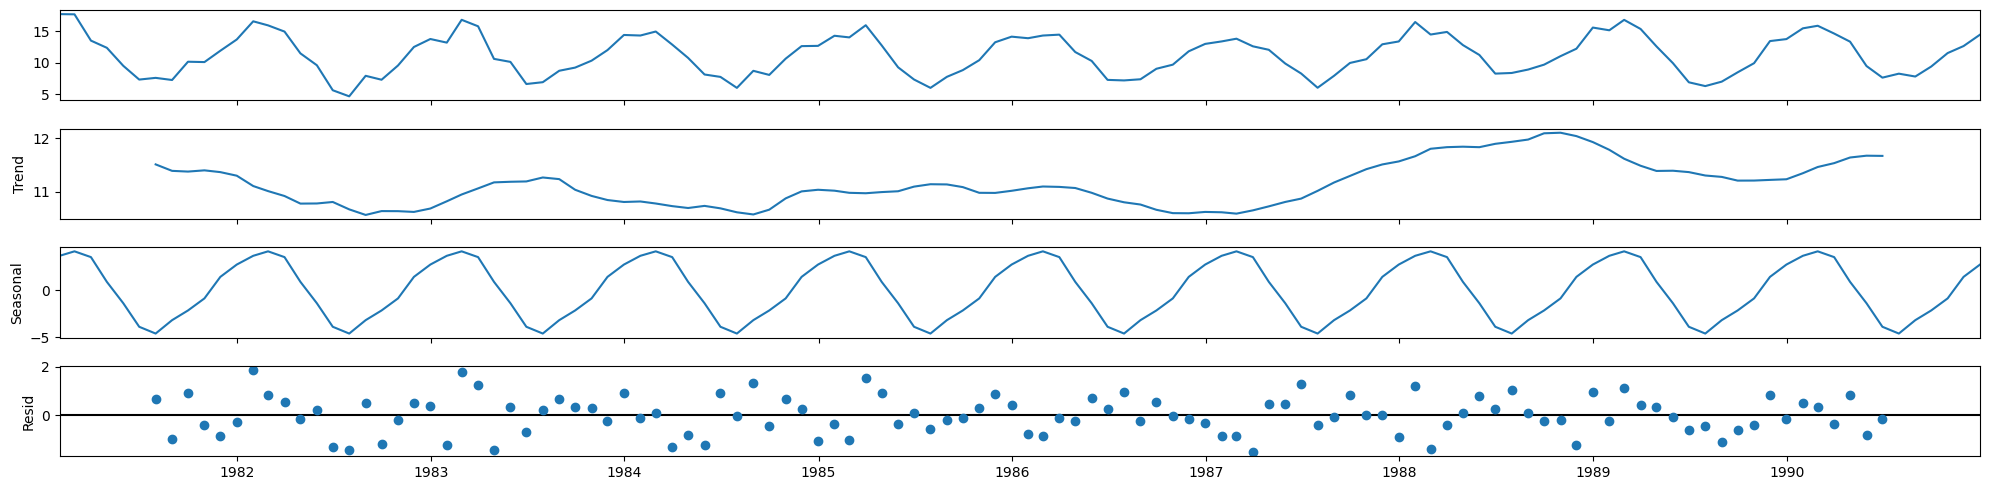

In [6]:
df_monthly = min_temp_data.resample('M').mean()

results2 = seasonal_decompose(df_monthly)

results2.plot()

## Create Training and Testing Data then Normalize Data

In [7]:
#Let's train the LSTM on 8 years of data and see how well it predicts the last two
train = df_monthly[:96]
test = df_monthly[96:]

In [8]:
# Scale data to range 0 - 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train.values)
scaled_test = scaler.fit_transform(test.values)

### Define the Time Series Generator
This parses the input data into "batches" - sets of data for training. The data scientist can play with the "lookback" period which is the size of the time window for training. For example, in this daily dataset if the lookback was 365, we would be passing it batches of 365 sequential data points at a time to predict the 366th value. Then the window would move one day forward and use days 2 - 366 to predict the 367th value. Temperature has daily and yearly periodicity so it's up to the scientist to decide how to allocate computing resources. Training on larger windows creates a larger model.

In [9]:
#generator using a 30 day window
look_back = 12 #the time window
n_features = 1 #the number of predictor features (we have 1 - time)

train_generator = TimeseriesGenerator(scaled_train, scaled_train,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

# Create a Simple LSTM Model

In [10]:
#Initializie model class
model = Sequential()
model.add(Input(shape=(look_back,n_features)))
#We will only add 1 LSTM cell block because there is only 1 input feature to predict temp (time)
model.add(LSTM(150))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

## Fit the Model

In [12]:
model.fit(train_generator, epochs=300, verbose=False)

/Users/ryangeygan/hacking/machine-learning/.venv-machine-learning/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [13]:
test_predictions = []

first_eval_batch = scaled_train[-look_back:]
current_batch = first_eval_batch.reshape((1, look_back, n_features))

for i in range(len(test) + 24):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch, verbose=False)[0]
    
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
     

In [14]:
transformed_pred = scaler.inverse_transform(test_predictions)

predictions = [x[0] for x in transformed_pred]

my_preds_list = [np.nan] * (144 - 48) + predictions

# Extend the DataFrame by 24 months
extension_dates = pd.date_range(start=df_monthly.index[-1] + pd.DateOffset(months=1), periods=24, freq='M')  # Add 24 months
extension_data = {'value': [None] * 24}  # Fill with None or NaN values, or specify your own values
extension_df = pd.DataFrame(extension_data, index=extension_dates)
extended_df = pd.concat([df_monthly, extension_df]).drop(columns=['value'])

extended_df['predicted_temp'] = my_preds_list

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_34990/985468261.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  extension_dates = pd.date_range(start=df_monthly.index[-1] + pd.DateOffset(months=1), periods=24, freq='M')  # Add 24 months


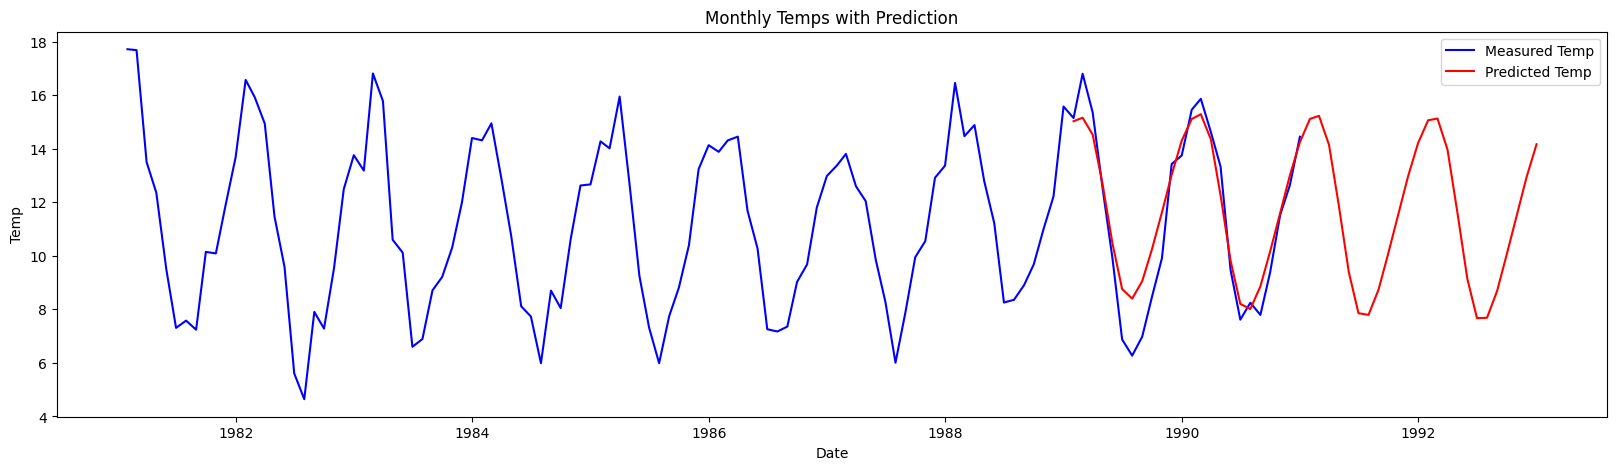

In [15]:
# Plotting
plt.rcParams['figure.figsize'] = [20, 5]

# Plot col1 in blue
plt.plot(extended_df.index, extended_df['min_temp'], color='blue', label='Measured Temp')

# Plot col2 in red
plt.plot(extended_df.index, extended_df['predicted_temp'], color='red', label='Predicted Temp')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Monthly Temps with Prediction')
plt.legend()

# Show plot
plt.show()

## Try to Improve the Model by Adding Another Source of Data
Let's see if we can add monthly max temps to the LSTM model to help predict the monthly min temps

In [16]:
max_temp_data = pd.read_csv('/Users/ryangeygan/hacking/Datasets/daily-max-temperatures.csv')

max_temp_data.set_index('Date', inplace=True)
max_temp_data.index = pd.date_range(start=min_temp_data.index[0], periods=len(min_temp_data), freq='D')
max_temp_data = max_temp_data.rename(columns={'Temperature':'max_temp'})

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_34990/1340362331.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_max = max_temp_data.resample('M').mean()


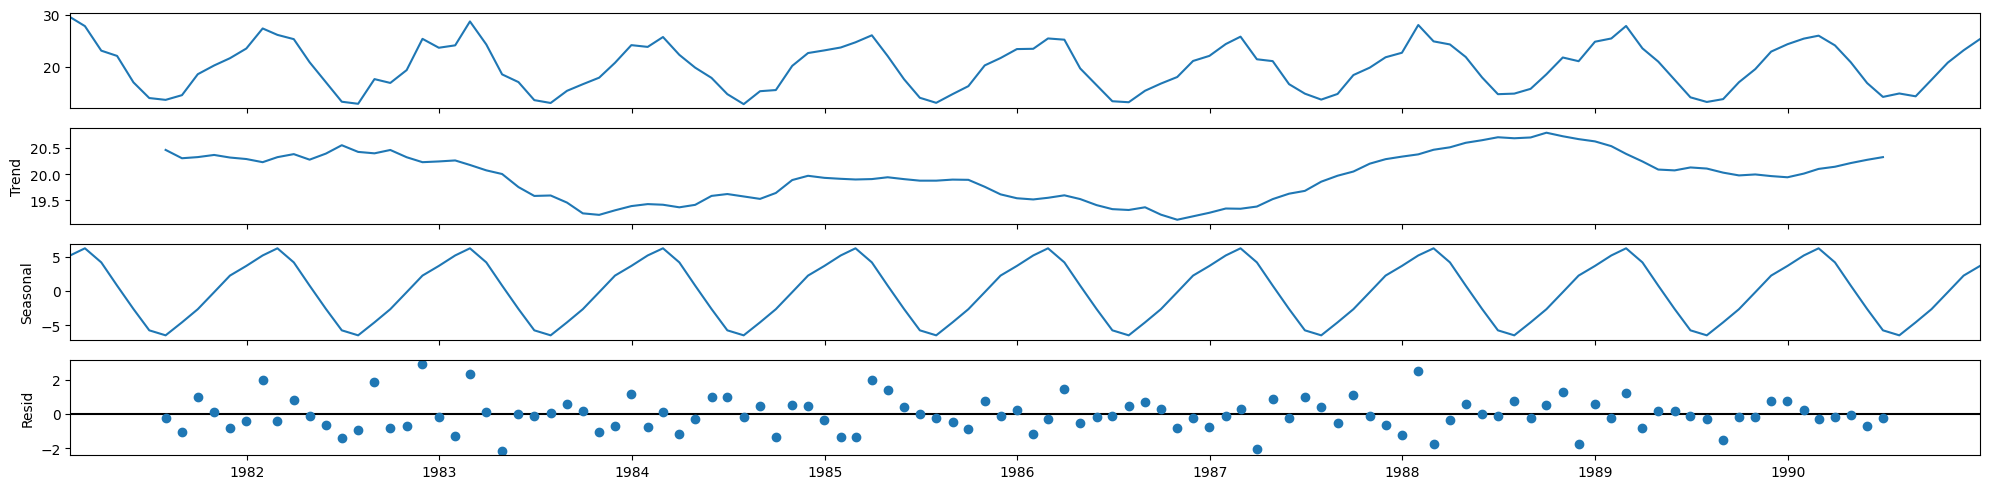

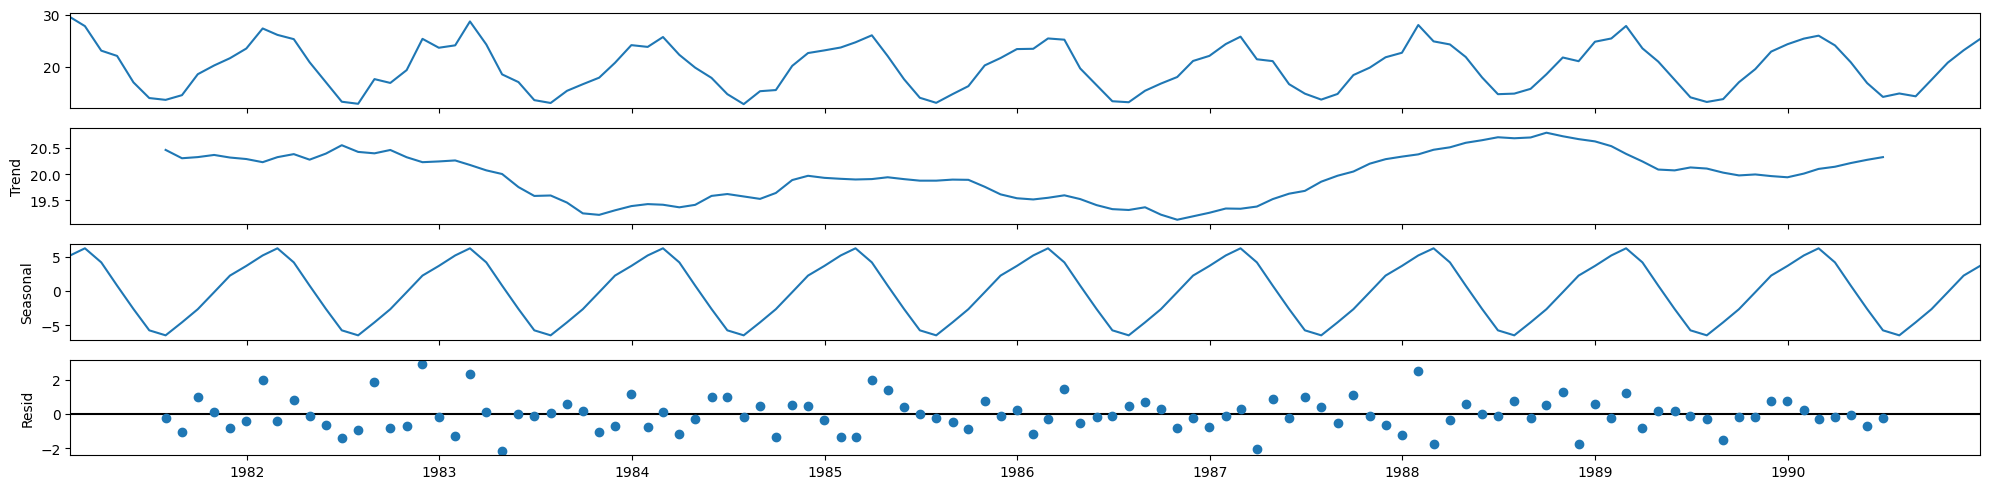

In [17]:
df_monthly_max = max_temp_data.resample('M').mean()

results3 = seasonal_decompose(df_monthly_max)

results3.plot()

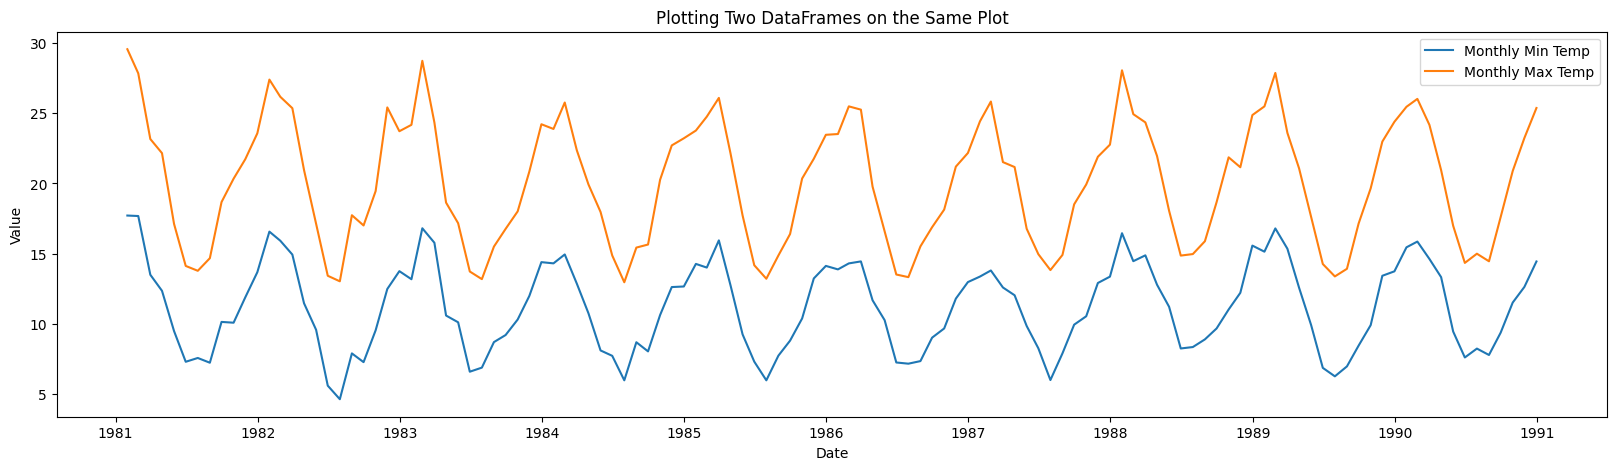

In [18]:
plt.rcParams['figure.figsize'] = [20, 5]

# Plot df1
plt.plot(df_monthly.index, df_monthly['min_temp'], label='Monthly Min Temp')

# Plot df2
plt.plot(df_monthly_max.index, df_monthly_max['max_temp'], label='Monthly Max Temp')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plotting Two DataFrames on the Same Plot')
plt.legend()

# Show plot
plt.show()

#### Note: Going to Try a Different Approach Using GRU layer instead of LSTM

In [19]:
df = pd.concat([df_monthly, df_monthly_max], axis=1).reset_index()
df = df.rename(columns={'index':'date'})
train_set_dates = pd.to_datetime(df['date'])

columns = list(df.columns[1:3])

df_train = df[columns].astype(float)

In [20]:
# Normalize the data using the Standard scaler
standard_scaler = MinMaxScaler()
scalar = standard_scaler.fit(df_train)
scaled_training_df = scalar.transform(df_train)

In [21]:
trainX = []
trainY = []

future_no_of_months = 1 # num of days to predict the future values
past_no_of_months = 12 # number of days on which the prediction is computed

for i in range(past_no_of_months, len(scaled_training_df) - future_no_of_months+1):
    trainX.append(scaled_training_df[i - past_no_of_months:i, 0:df_train.shape[1]])
    trainY.append(scaled_training_df[i + future_no_of_months - 1:i + future_no_of_months, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [22]:
model2 = Sequential()
model2.add(Input(shape=(trainX.shape[1], trainX.shape[2])))
model2.add(GRU(64, activation='relu', return_sequences=True))
model2.add(GRU(32, activation='relu', return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(trainY.shape[1]))
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 64)         │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,497 (87.88 KB)

 Trainable params: 22,497 (87.88 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
display(trainX.shape)
display(trainY.shape)

(108, 12, 2)

(108, 1)

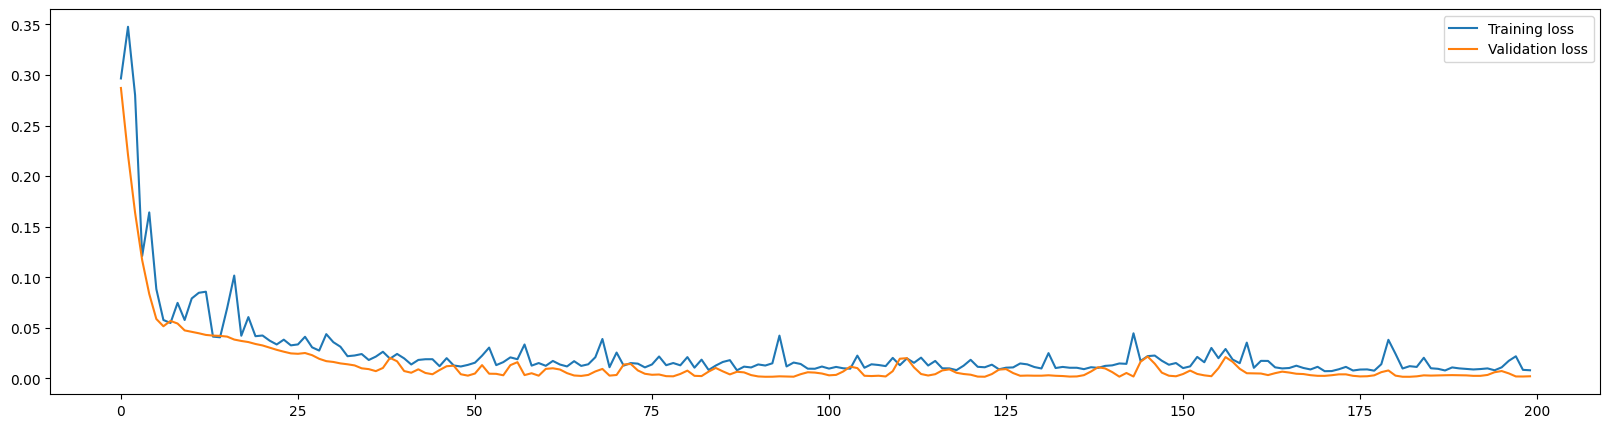

In [24]:
# fit the model
history = model2.fit(trainX, trainY, epochs=200, validation_split=0.1, verbose=False)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [25]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 24
n_days_for_prediction=24  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_set_dates)[-n_past], periods=n_days_for_prediction, freq='1m').tolist() # instead of us_bd we can give '1d' etc.

predict_period_dates

#Make prediction
prediction = model2.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

# predict the future price
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_pred_future = scalar.inverse_transform(prediction_copies)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'min_temp':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

original = df[['date', 'min_temp']]
original['date']=pd.to_datetime(original['date'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_34990/2234057748.py:8: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  predict_period_dates = pd.date_range(list(train_set_dates)[-n_past], periods=n_days_for_prediction, freq='1m').tolist() # instead of us_bd we can give '1d' etc.
/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_34990/2234057748.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


## Looks Like It Worked

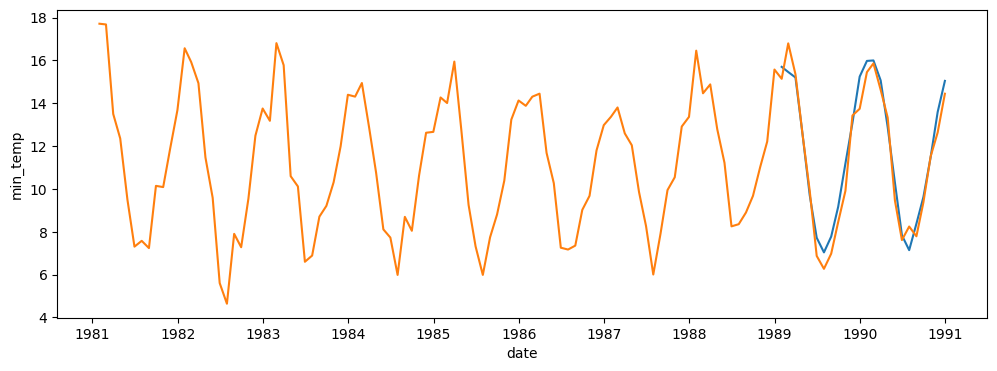

In [26]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df_forecast, x='date', y='min_temp', )
sns.lineplot(data=original, x='date', y='min_temp')
plt.show()